In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q kaggle
!cp /content/drive/MyDrive/colab/kaggle.json /content/kaggle.json
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d jainilcoder/online-payment-fraud-detection

Dataset URL: https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection
License(s): CC0-1.0
online-payment-fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/online-payment-fraud-detection.zip

Archive:  /content/online-payment-fraud-detection.zip
replace onlinefraud.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: onlinefraud.csv         

# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
def load (path):
    df = pd.read_csv(path)
    return df

file_path = "/content/onlinefraud.csv"
df = load (file_path)

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


# Explor Data

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.isna().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# customer starting the transaction
print(df["nameOrig"].value_counts())

nameOrig
C1530544995    3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
              ..
C1567523029    1
C644777639     1
C1256645416    1
C1231536757    1
C1971151096    1
Name: count, Length: 6353307, dtype: int64


In [ ]:
# recipient of the transaction
print(df["nameDest"].value_counts())

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M367627425       1
M1902904124      1
M242332837       1
M281573812       1
M1010678443      1
Name: count, Length: 2722362, dtype: int64


Duplicate columns: []
isFraud           8213
isFlaggedFraud      16
dtype: int64


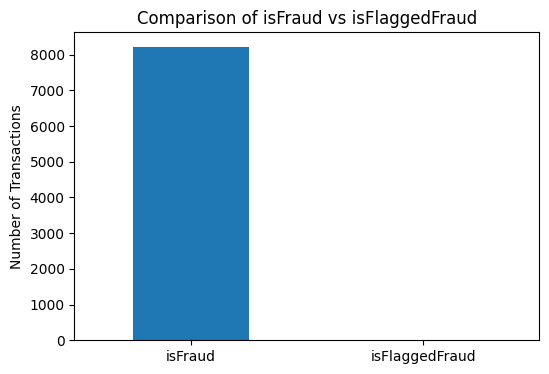

In [ ]:
# 1. Check duplicate columns
duplicate_cols = df.columns[df.columns.duplicated()]
print("Duplicate columns:", list(duplicate_cols))

# 2. Compare 'isFraud' vs 'isFlaggedFraud'
fraud_counts = df[['isFraud', 'isFlaggedFraud']].sum()
print(fraud_counts)

# 3. Plot bar chart
plt.figure(figsize=(6,4))
fraud_counts.plot(kind='bar')
plt.title("Comparison of isFraud vs isFlaggedFraud")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
plt.show()

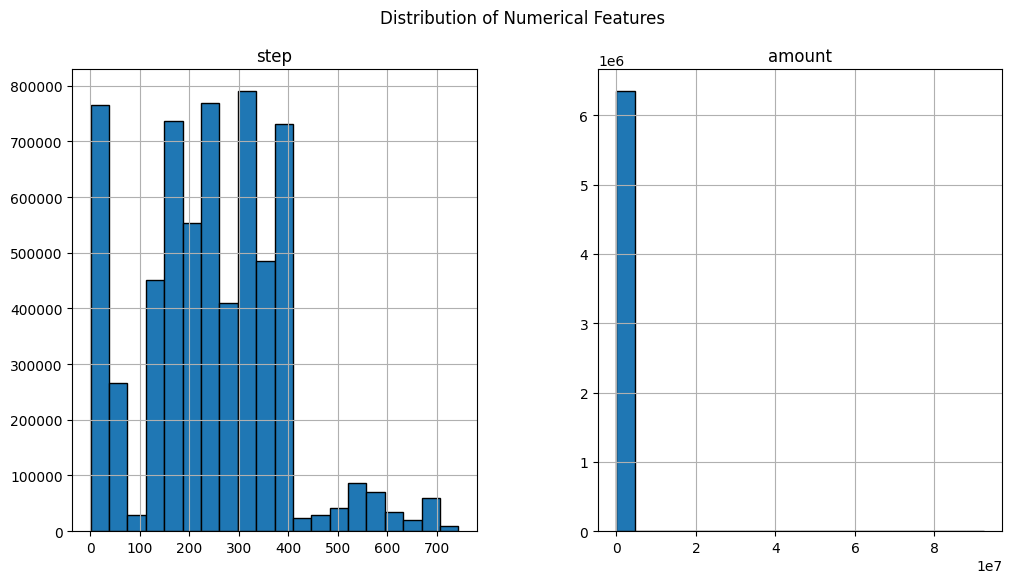

In [ ]:
numeric_features = ["step", "amount"]

df[numeric_features].hist(figsize=(12,6), bins=20, edgecolor="black")
plt.suptitle("Distribution of Numerical Features")
plt.show()

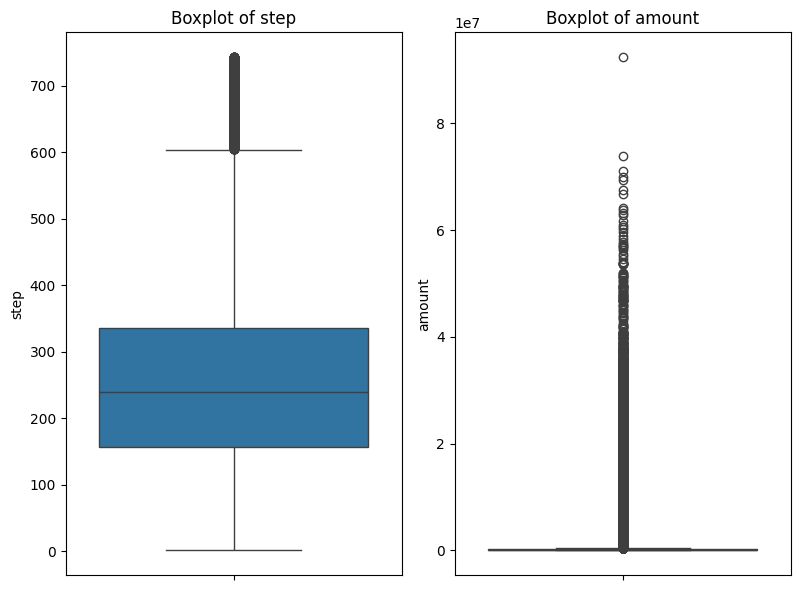

In [ ]:
plt.figure(figsize=(12,6))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

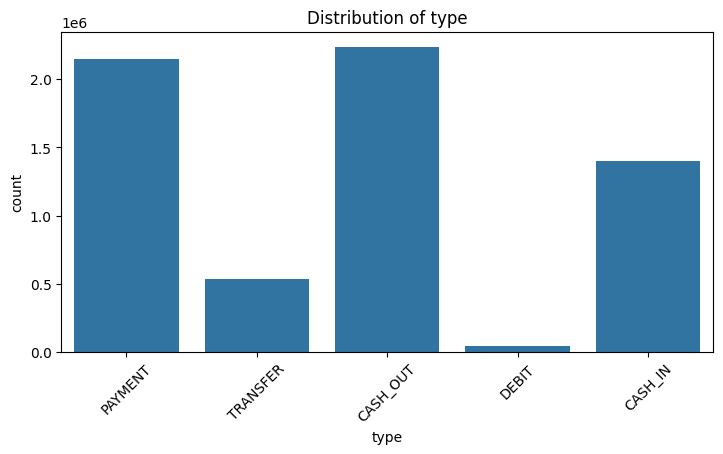

In [ ]:
categorical_features = ["type"]

plt.figure(figsize=(14,8))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

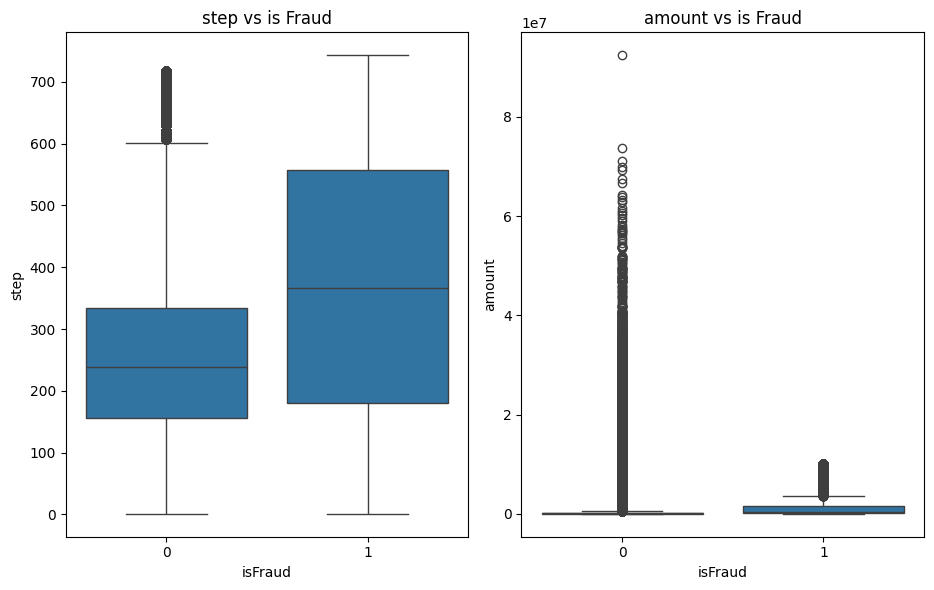

In [ ]:
plt.figure(figsize=(14,6))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="isFraud", y=col, data=df)
    plt.title(f"{col} vs is Fraud")
plt.tight_layout()
plt.show()

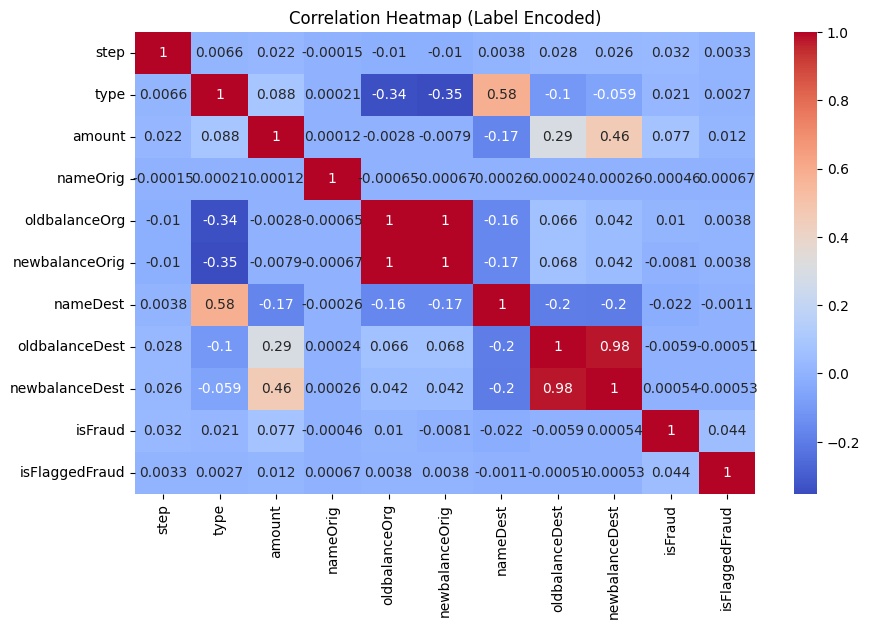

In [ ]:
# Copy dataset
df_corr = df.copy()

# Encode categorical features for correlation
categorical_features = ["type" ,"nameOrig" ,"nameDest"]

le = LabelEncoder()
for col in categorical_features:
    df_corr[col] = le.fit_transform(df_corr[col])

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Label Encoded)")
plt.show()

# Preprocessing Data

In [ ]:
def drop_columns(df):
    return df.drop(columns=["nameOrig", "nameDest", "isFlaggedFraud"], errors="ignore")

df = drop_columns(df)

print("Columns dropped successfully!\n")

Columns dropped successfully!



In [ ]:
def downcast_dtypes(df):

    float_cols = df.select_dtypes(include=["float64"]).columns
    df[float_cols] = df[float_cols].astype("float32")

    int_cols = df.select_dtypes(include=["int64"]).columns
    df[int_cols] = df[int_cols].astype("int32")

    print(f"Downcasting complete. Floats → float32, Ints → int32")
    return df

df = downcast_dtypes(df)

print("After downcasting:")
print(df.dtypes)

Downcasting complete. Floats → float32, Ints → int32
After downcasting:
step                int32
type               object
amount            float32
oldbalanceOrg     float32
newbalanceOrig    float32
oldbalanceDest    float32
newbalanceDest    float32
isFraud             int32
dtype: object


In [ ]:
def check_nulls(df):
 return df.isnull().sum()

print("Null values in each column:\n")
print(check_nulls(df))

Null values in each column:

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64


In [ ]:
def numerical_summary(df):
    print("\nNumerical Columns Summary:\n")
    print(df.describe())


print("\n=== Numerical Columns Summary ===")
numerical_summary(df)


=== Numerical Columns Summary ===

Numerical Columns Summary:

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338834e+05    8.551137e+05   
std    1.423320e+02  5.991358e+05   2.831753e+06    2.862818e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06  
mean     1.100702e+06    1.224997e+06  1.290820e-03  
std      3.369338e+06    3.629806e+06  3.590480e-02  
min      0.000000e+00    0.000000e+00  0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00  

# Feature Engineering

In [ ]:
def add_relative_amount(df):

    df["relativeAmount"] = df["amount"] / (df["oldbalanceOrg"] + 1)
    return df

In [ ]:
def add_diffOrig(df):

    df["diffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"] - df["amount"]
    return df

In [ ]:
def add_diffDest(df):

    df["diffDest"] = df["newbalanceDest"] - df["oldbalanceDest"] - df["amount"]
    return df

In [ ]:
def add_transaction_hour(df):

    df["hour"] = df["step"] % 24
    return df

In [ ]:
df = add_relative_amount(df)
df = add_diffOrig(df)
df = add_diffDest(df)
df = add_transaction_hour(df)


print("✅ Transaction type encoded (one-hot).")
print("✅ Relative amount feature added.")
print("✅ diffOrig feature added.")
print("✅ diffDest feature added.")
print("✅ Transaction hour feature added.")


✅ Transaction type encoded (one-hot).
✅ Relative amount feature added.
✅ diffOrig feature added.
✅ diffDest feature added.
✅ Transaction hour feature added.


# Distribution of Feature when isFraud = 1

In [ ]:
df_isFraud = df[df['isFraud'] == 1]
df_isFraud

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,relativeAmount,diffOrig,diffDest,hour
2,1,TRANSFER,181.000,181.000,0.0,0.000000e+00,0.000,1,0.994505,0.0,-181.0,1
3,1,CASH_OUT,181.000,181.000,0.0,2.118200e+04,0.000,1,0.994505,0.0,-21363.0,1
251,1,TRANSFER,2806.000,2806.000,0.0,0.000000e+00,0.000,1,0.999644,0.0,-2806.0,1
252,1,CASH_OUT,2806.000,2806.000,0.0,2.620200e+04,0.000,1,0.999644,0.0,-29008.0,1
680,1,TRANSFER,20128.000,20128.000,0.0,0.000000e+00,0.000,1,0.999950,0.0,-20128.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.125,339682.125,0.0,0.000000e+00,339682.125,1,0.999997,0.0,0.0,23
6362616,743,TRANSFER,6311409.500,6311409.500,0.0,0.000000e+00,0.000,1,1.000000,0.0,-6311409.5,23
6362617,743,CASH_OUT,6311409.500,6311409.500,0.0,6.848884e+04,6379898.000,1,1.000000,0.0,-0.5,23
6362618,743,TRANSFER,850002.500,850002.500,0.0,0.000000e+00,0.000,1,0.999999,0.0,-850002.5,23


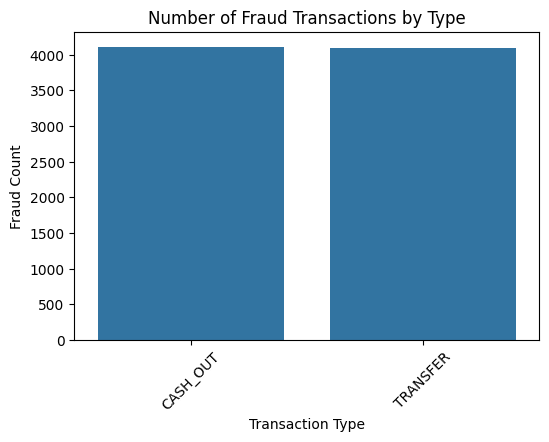

In [ ]:
fraud_by_type = df[df["isFraud"] == 1]["type"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)
plt.title("Number of Fraud Transactions by Type")
plt.ylabel("Fraud Count")
plt.xlabel("Transaction Type")
plt.xticks(rotation=45)
plt.show()


## diffOrig
ถ้าไม่เท่ากับ 0 → ธุรกรรมปลอม / balance ถูกแก้ไข

In [ ]:
df_isFraud[df_isFraud['diffOrig'] != 0]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,relativeAmount,diffOrig,diffDest,hour
724,1,CASH_OUT,4.160013e+05,0.000000e+00,0.000000e+00,102.000000,9.291620e+06,1,4.160013e+05,-4.160013e+05,8.875517e+06,1
1911,1,CASH_OUT,1.328426e+05,4.499080e+03,0.000000e+00,0.000000,1.328426e+05,1,2.952006e+01,-1.283436e+05,0.000000e+00,1
14861,8,CASH_OUT,1.817281e+05,0.000000e+00,0.000000e+00,11397.000000,1.844778e+05,1,1.817281e+05,-1.817281e+05,-8.647344e+03,8
25875,8,TRANSFER,1.078014e+06,0.000000e+00,0.000000e+00,0.000000,9.707497e+05,1,1.078014e+06,-1.078014e+06,-1.072641e+05,8
60853,9,TRANSFER,9.944532e+05,1.437371e+06,4.429177e+05,194812.765625,6.657437e+05,1,6.918552e-01,6.250000e-02,-5.235222e+05,9
...,...,...,...,...,...,...,...,...,...,...,...,...
6357390,710,TRANSFER,1.000000e+07,3.741826e+07,2.741827e+07,0.000000,0.000000e+00,1,2.672492e-01,-2.000000e+00,-1.000000e+07,14
6361721,718,TRANSFER,1.000000e+07,1.974904e+07,9.749043e+06,0.000000,0.000000e+00,1,5.063536e-01,-1.000000e+00,-1.000000e+07,22
6362460,730,TRANSFER,1.000000e+07,1.731626e+07,1.731626e+07,0.000000,0.000000e+00,1,5.774921e-01,-1.000000e+07,-1.000000e+07,10
6362462,730,TRANSFER,7.316255e+06,1.731626e+07,1.731626e+07,0.000000,0.000000e+00,1,4.225079e-01,-7.316255e+06,-7.316255e+06,10


## diffDest
ส่วนต่างผิดปกติของยอดบัญชีปลายทาง (destination)

ธุรกรรมที่ถูกต้องควรเป็น: <br>
newbalanceDest == oldbalanceDest + amount

In [ ]:
df_isFraud[df_isFraud['newbalanceOrig'] == df_isFraud['oldbalanceDest'] + df_isFraud['amount']]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,relativeAmount,diffOrig,diffDest,hour
2736446,212,TRANSFER,4.953893e+06,4.953893e+06,4.953893e+06,0.0,0.0,1,1.000000,-4.953893e+06,-4.953893e+06,20
2736447,212,CASH_OUT,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1,0.000000,0.000000e+00,0.000000e+00,20
3247297,250,TRANSFER,1.343002e+06,1.343002e+06,1.343002e+06,0.0,0.0,1,0.999999,-1.343002e+06,-1.343002e+06,10
3247298,250,CASH_OUT,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1,0.000000,0.000000e+00,0.000000e+00,10
3760288,279,TRANSFER,5.366244e+05,5.366244e+05,5.366244e+05,0.0,0.0,1,0.999998,-5.366244e+05,-5.366244e+05,15
5563713,387,TRANSFER,4.892193e+06,4.892193e+06,4.892193e+06,0.0,0.0,1,1.000000,-4.892193e+06,-4.892193e+06,3
6168499,554,TRANSFER,3.576297e+06,3.576297e+06,3.576297e+06,0.0,0.0,1,1.000000,-3.576297e+06,-3.576297e+06,2
6205439,586,TRANSFER,3.538742e+05,3.538742e+05,3.538742e+05,0.0,0.0,1,0.999997,-3.538742e+05,-3.538742e+05,10
6266413,617,TRANSFER,2.542664e+06,2.542664e+06,2.542664e+06,0.0,0.0,1,1.000000,-2.542664e+06,-2.542664e+06,17
6266414,617,CASH_OUT,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1,0.000000,0.000000e+00,0.000000e+00,17


# ML Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

def preprocessing_pipeline(df, target_col="isFraud", test_size=0.2, random_state=42, drop_leaky=True):
    # Remove leaky feature
    if drop_leaky and "relativeAmount" in df.columns:
        df = df.drop(columns=["relativeAmount"])

    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Stratified Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Numeric features
    numeric_features = X.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns
    categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns

    # Numeric transformer
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Categorical transformer
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    # Full pipeline
    pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

    # Transform
    X_train_processed = pipeline.fit_transform(X_train)
    X_test_processed = pipeline.transform(X_test)

    return X_train_processed, X_test_processed, y_train, y_test, pipeline


In [ ]:
# Example usage
X_train, X_test, y_train, y_test, pipeline = preprocessing_pipeline(df, target_col="isFraud")

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Class distribution in train:\n", y_train.value_counts(normalize=True))
print("Class distribution in test:\n", y_test.value_counts(normalize=True))

Train shape: (5090096, 13)
Test shape: (1272524, 13)
Class distribution in train:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64
Class distribution in test:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [ ]:
# ratio calculate karo
neg, pos = y_train.value_counts()
scale = neg / pos
print("scale_pos_weight =", scale)

# XGB model with imbalance handling
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale,   # 👈 imbalance handled here
    n_jobs=-1
)

# Train
xgb.fit(X_train, y_train)

scale_pos_weight = 773.7482496194825


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# Predict
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:,1]

# Evaluation
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.9995812473999788
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.91      0.99      0.95      1643

    accuracy                           1.00   1272524
   macro avg       0.96      0.99      0.97   1272524
weighted avg       1.00      1.00      1.00   1272524



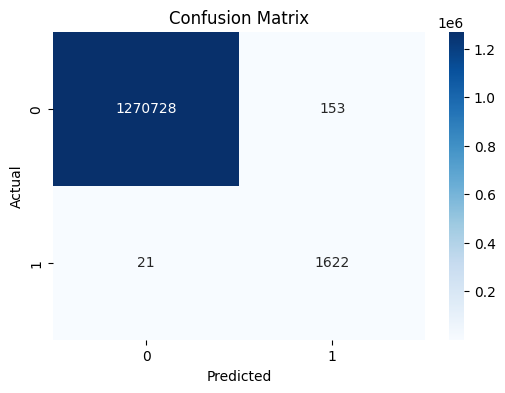

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


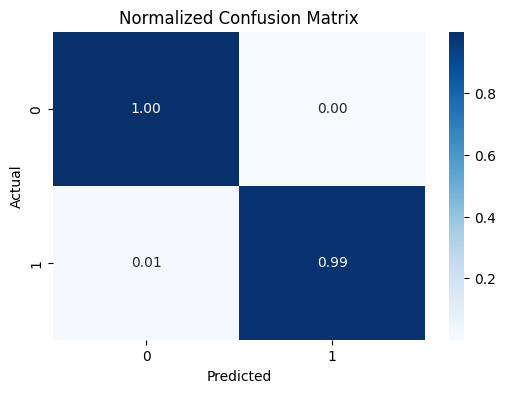

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Feature Importance

                Feature  Importance
3   num__newbalanceOrig    0.603329
6         num__diffOrig    0.360805
1           num__amount    0.012678
11    cat__type_PAYMENT    0.011974
7         num__diffDest    0.002932
4   num__oldbalanceDest    0.002271
2    num__oldbalanceOrg    0.001452
10      cat__type_DEBIT    0.001107
12   cat__type_TRANSFER    0.000905
0             num__step    0.000829
9    cat__type_CASH_OUT    0.000731
5   num__newbalanceDest    0.000528
8             num__hour    0.000459


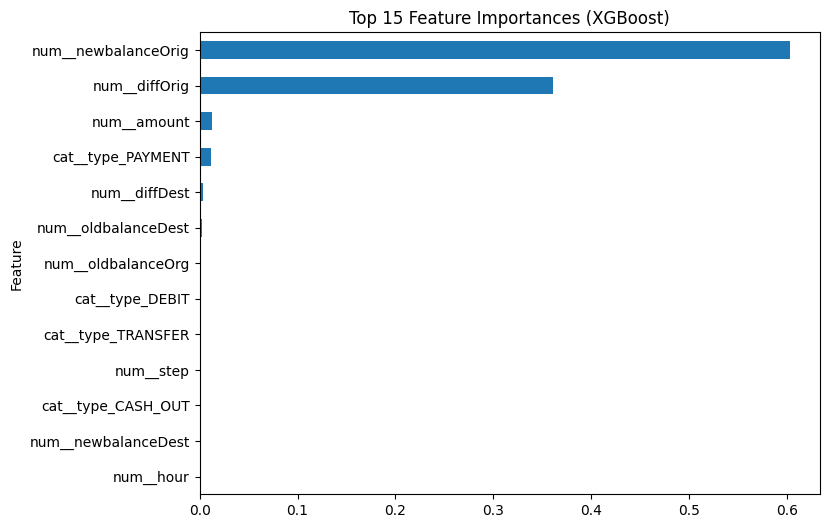

In [ ]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Train XGBoost
xgb_model = XGBClassifier(
    scale_pos_weight=773.7482496194825,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb_model.fit(X_train, y_train)

# ✅ Get feature names from pipeline
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

# ✅ Feature importance values
importances = xgb_model.feature_importances_

# ✅ DataFrame bana lo
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# ✅ Top features print karo
print(feat_imp.head(15))

# ✅ Plot karo
feat_imp.head(15).plot(kind="barh", x="Feature", y="Importance", figsize=(8,6), legend=False)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()


# Export Model

In [ ]:
import pickle

with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

In [ ]:
with open("preprocessing_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

# Test Use

In [ ]:
import pickle
import pandas as pd

with open("xgb_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

with open("preprocessing_pipeline.pkl", "rb") as f:
    loaded_pipeline = pickle.load(f)

In [ ]:
def drop_columns(df):
    return df.drop(columns=["nameOrig", "nameDest", "isFlaggedFraud"], errors="ignore")

def add_diffOrig(df):
    df["diffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"] - df["amount"]
    return df

def add_diffDest(df):
    df["diffDest"] = df["newbalanceDest"] - df["oldbalanceDest"] - df["amount"]
    return df

def add_transaction_hour(df):
    df["hour"] = df["step"] % 24
    return df

In [ ]:
df_test = df.copy()
df_test.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df_test = drop_columns(df_test)
df_test = add_diffOrig(df_test)
df_test = add_diffDest(df_test)
df_test = add_transaction_hour(df_test)

In [ ]:
if "relativeAmount" in df_test.columns:
    df_test = df_test.drop(columns=["relativeAmount"])
if "isFraud" in df_test.columns:
    X_new = df_test.drop(columns=["isFraud"])
else:
    X_new = df_test

In [ ]:
X_new_processed = loaded_pipeline.transform(X_new)

In [ ]:
X_new_processed[:30].shape

(30, 13)

In [ ]:
y_pred = loaded_model.predict(X_new_processed[:200])

y_prob = loaded_model.predict_proba(X_new_processed[:200])[:, 1]

print("ผลการทำนาย:", y_pred.shape)

ผลการทำนาย: (200,)


In [ ]:
y_pred

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [ ]:
y_prob

array([2.97381426e-08, 1.00180948e-08, 9.99997616e-01, 9.99948740e-01,
       4.19548627e-08, 5.50418555e-08, 2.63345790e-08, 2.84183113e-08,
       6.10288851e-07, 2.58578972e-08, 1.07699875e-02, 2.51360466e-09,
       4.64428140e-08, 5.03140518e-06, 1.64669061e-08, 2.83072557e-04,
       1.34941297e-06, 4.37730785e-09, 7.36024353e-09, 1.11126457e-04,
       3.74574043e-08, 8.34741604e-06, 1.16932151e-05, 1.84945108e-08,
       3.05082212e-05, 4.45885888e-07, 2.29862991e-08, 3.99668210e-07,
       1.25698671e-06, 7.07992626e-07, 6.57202918e-07, 7.41394103e-07,
       4.67278596e-07, 3.90057465e-07, 3.90057465e-07, 1.42928354e-06,
       4.99420366e-07, 1.50289630e-08, 1.80088033e-08, 1.16520456e-08,
       1.57132422e-06, 1.02608331e-08, 1.11310192e-06, 8.54991356e-07,
       3.90057465e-07, 7.46218909e-09, 4.72095110e-07, 5.82972134e-05,
       1.99255792e-05, 3.54062172e-06, 2.23778915e-08, 1.03008596e-03,
       1.05485523e-08, 7.66429586e-09, 3.57797560e-08, 1.18668231e-08,
      

# For Client Web

In [ ]:
web_df = df[:3500000].copy()
web_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3499995,259,TRANSFER,385627.24,C1620559845,0.0,0.00,C602777720,1216077.89,1601705.13,0.0,0.0
3499996,259,TRANSFER,31159.78,C2129257603,0.0,0.00,C955077175,376179.14,407338.92,0.0,0.0
3499997,259,TRANSFER,471431.20,C1633041457,0.0,0.00,C356001688,520294.55,891682.65,0.0,0.0
3499998,259,TRANSFER,1365936.57,C474110646,0.0,0.00,C1052951038,8922964.14,10288900.71,0.0,0.0


In [ ]:
web_df.to_csv('transactions.csv', index=False)

In [ ]:
import zipfile
with zipfile.ZipFile('transactions.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('transactions.csv')